In [1]:
%load_ext autoreload
%autoreload 2
from process_rosbags_in_directory import process_rosbags_in_directory, calculate_sfpw
import numpy as np
#result_path = "/media/fstark/6d50b273-a557-47f3-b7a9-9296ecddf260/COMPARISON_NEWDATA"
result_path = "/home/dfki.uni-bremen.de/fstark/Downloads/COMPARISON_NEWDATA"

import matplotlib as plt

# Ensure matplotlib uses Type 1 (vector) fonts for PDF outputs
plt.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType (42) instead of Type 3
plt.rcParams['ps.fonttype'] = 42   # For saving as EPS files, same setting


In [2]:
def tag_parser_fun(exp_folder : str, exp_name : str, bag_data : dict):
    res = {}
    # Meta data
    res["target_pc"] = exp_folder.split("-")[0]
    res["experiment_tag"] = exp_folder.split("-")[2]
    res["N"] = exp_folder.split("-")[1]
    if len(exp_name.split("-")) > 1: 
        if exp_name.split("-")[0].__contains__("HPIPM"):
            res["mpc_solver"] = exp_name.split("-")[0].split('_')[-1] + "-" + exp_name.split("-")[1]
        else:
            res["mpc_solver"] = exp_name.split("-")[0].split('_')[-1] 
        
        res["cond_type"] = "_".join(exp_name.split("-")[0].split('_')[:-1])
        res["wbc_solver"] = exp_name.split("-")[5]
        res["cond_N"] = float(exp_name.split("-")[2])
        res["experiment"] = exp_name.split("-")[3]
        res["trial"] = int(exp_name.split("-")[4])

        if len(exp_name.split("-")) > 6:
            res["wbc_scene"] = exp_name.split("-")[6]
        else:
            res["wbc_scene"] = "AccelerationSceneReducedTSID"
            

    else: ##Backup case for old jackob data
        idxof = 0
        res["cond_type"] = "_".join(exp_name.split("_")[:2])
        res["mpc_solver"] = exp_name.split("_")[2]
        
        if len(exp_name.split("_")) == 7: # for veryo old jakob experiments that have no HPIPM mode encoded
            idxof = -1
            if exp_name.split("_")[2] == "HPIPM":
                res["mpc_solver"] += ("-SPEED")
        else:
            if exp_name.split("_")[2] == "HPIPM":
                res["mpc_solver"] += ("-" + exp_name.split("_")[3])
            
            if exp_name.split("_")[4] == "ABS":
                res["mpc_solver"] += ("_" + exp_name.split("_")[4])
                idxof = 1
            
        res["wbc_solver"] = "EiquadprogSolver"
        res["cond_N"] = float(exp_name.split("_")[4+idxof])
        res["experiment"] = exp_name.split("_")[5 +idxof] + "_" + exp_name.split("_")[6+idxof]
        res["trial"] = int(exp_name.split("_")[7+idxof])
        res["wbc_scene"] = "AccelerationSceneReducedTSID"
    
    res["failed"] = bag_data["failed"]

    return res


def pre_process_data(exp_folder : str, exp_name : str, bag_data : dict):
    res = {}
    mpc_solve_time = np.array(bag_data["solve_time"]["acados_solve_qp_time"])
    res["mpc_solve_time_over"] = [float((mpc_solve_time > 0.01).sum()) / float(len(mpc_solve_time))]
    res["avg_mpc_solve_time"] = [mpc_solve_time.mean()]
    res["avg_mpc_solve_time_min"] = [mpc_solve_time.min()]
    res["avg_mpc_solve_time_max"] = [mpc_solve_time.max()]
    res["avg_mpc_solve_time_median"] = [np.median(mpc_solve_time)]
    res["avg_mpc_solve_time_q25"] = [np.quantile(mpc_solve_time,0.25)]
    res["avg_mpc_solve_time_q75"] = [np.quantile(mpc_solve_time,0.75)]

    mpc_solve_time = np.array(bag_data["solve_time"]["acados_total_time"])
    res["mpc_total_time_over"] = [float((mpc_solve_time > 0.01).sum()) / float(len(mpc_solve_time))]
    res["avg_mpc_total_time"] = [mpc_solve_time.mean()]
    res["avg_mpc_total_time_min"] = [mpc_solve_time.min()]
    res["avg_mpc_total_time_max"] = [mpc_solve_time.max()]
    res["avg_mpc_total_time_median"] = [np.median(mpc_solve_time)]
    res["avg_mpc_total_time_q25"] = [np.quantile(mpc_solve_time,0.25)]
    res["avg_mpc_total_time_q75"] = [np.quantile(mpc_solve_time,0.75)]
        
    res["avg_mpc_condensing_time"] = [np.array(bag_data["solve_time"]["acados_condensing_time"]).mean()]
    res["avg_wbc_solve_time"] = [np.array(bag_data["wbc_solve_time"]["qp_solve_time"]).mean()]
    res["avg_wbc_update_time"] = [np.array(bag_data["wbc_solve_time"]["qp_update_time"]).mean()]
    res["avg_wbc_total_time"] = [np.array(bag_data["wbc_solve_time"]["total_time"]).mean()]
    res["avg_wbc_total_time_ms"] = [(np.array(bag_data["wbc_solve_time"]["total_time"]) * 1000.).mean()]

    res["avg_watts"] = [np.array(bag_data["cpu_power_consumption"]["data"]).mean()]
    
    sfpw_mpc = calculate_sfpw(np.vstack((bag_data["solve_time"]["recv_timestamp_ns"],bag_data["solve_time"]["acados_total_time"])),
                                         np.vstack((bag_data["cpu_power_consumption"]["recv_timestamp_ns"],bag_data["cpu_power_consumption"]["data"]))
                                         )[1,:]
    
    res["avg_mpc_sfpw"] = [sfpw_mpc.mean()]
    res["avg_mpc_sfpw_min"] = [sfpw_mpc.min()]
    res["avg_mpc_sfpw_max"] = [sfpw_mpc.max()]
    res["avg_mpc_sfpw_median"] = [np.median(sfpw_mpc)]
    res["avg_mpc_sfpw_q25"] = [np.quantile(sfpw_mpc,0.25)]
    res["avg_mpc_sfpw_q75"] = [np.quantile(sfpw_mpc,0.75)]


    res["avg_wbc_sfpw"] = [calculate_sfpw(np.vstack((bag_data["wbc_solve_time"]["recv_timestamp_ns"],bag_data["wbc_solve_time"]["total_time"])),
                                         np.vstack((bag_data["cpu_power_consumption"]["recv_timestamp_ns"],bag_data["cpu_power_consumption"]["data"]))
                                         )[1,:].mean()]
    
    return res

def time_wise_data_mpc(exp_folder : str, exp_name : str, bag_data : dict):
    res = {}

    res["recv_timestamp"] = np.array(bag_data["solve_time"]["recv_timestamp_ns"]).astype(float)
    res["recv_timestamp"] -= res["recv_timestamp"].min()
    res["recv_timestamp"] *= 1.0E-9
    res["mpc_total_time"] = bag_data["solve_time"]["acados_total_time"]
    res["mpc_condensing_time"] = bag_data["solve_time"]["acados_condensing_time"]
    res["mpc_solve_time"] = np.array(bag_data["solve_time"]["acados_solve_qp_time"])
    res["mpc_solve_time_ms"] = res["mpc_solve_time"] * 1000.
    res["mpc_interface_time"] = bag_data["solve_time"]["acados_interface_time"]
    res["mpc_sfpw"] = calculate_sfpw(np.vstack((bag_data["solve_time"]["recv_timestamp_ns"],bag_data["solve_time"]["acados_total_time"])),
                                         np.vstack((bag_data["cpu_power_consumption"]["recv_timestamp_ns"],bag_data["cpu_power_consumption"]["data"]))
                                         )[1,:]
    
    return res


    


def time_wise_data_wpc(exp_folder : str, exp_name : str, bag_data : dict):
    res = {}
    res["wbc_total_time"] = np.array(bag_data["wbc_solve_time"]["total_time"])
    res["wbc_total_time_ms"] = res["wbc_total_time"] * 1000.
    
    res["wbc_solve_time"] = np.array(bag_data["wbc_solve_time"]["qp_solve_time"])
    #res["wbc_solve_time_ms"] = 1000. * res["wbc_solve_time"]
    
    res["wbc_update_time"] = np.array(bag_data["wbc_solve_time"]["qp_update_time"])
    #res["wbc_update_time_ms"] = 1000. * res["wbc_update_time"]

    #res["wbc_interface_time"] = res["wbc_total_time"] - res["wbc_solve_time"] - res["wbc_update_time"] 
    #res["wbc_interface_time_ms"] = 1000. * res["wbc_interface_time"]

    
    
    res["wbc_sfpw"] = calculate_sfpw(np.vstack((bag_data["wbc_solve_time"]["recv_timestamp_ns"],bag_data["wbc_solve_time"]["total_time"])),
                                         np.vstack((bag_data["cpu_power_consumption"]["recv_timestamp_ns"],bag_data["cpu_power_consumption"]["data"]))
                                         )[1,:]
    
    return res


pre_proccesed_data = {}
mpc_data = {}
wbc_data = {}

process_rosbags_in_directory([pre_proccesed_data, mpc_data, wbc_data], result_path, tag_parser_fun, [pre_process_data, time_wise_data_mpc, time_wise_data_wpc])


register custom message: float64      period
float64[4]   duty_factor
float64[4]   phase_offset
bool[4]      contact
float64[4]   phase
uint8        gait_sequencer
uint8        SIMPLE=0
uint8        ADAPTIVE=1
uint8        BIOINSPIRED=2
register custom message: std_msgs/Header header
geometry_msgs/PoseWithCovariance pose
geometry_msgs/TwistWithCovariance twist
geometry_msgs/Accel acceleration
JointState joint_state
bool[4] foot_contact
float64[12] ground_contact_force # 4 times xyz
bool belly_contact

register custom message: std_msgs/Header header

uint32 num_early_contacts
uint32 num_mpc_solver_overtime
uint32 num_wbc_overtime
uint32 num_mpc_solver_fail
uint32 num_wbc_solver_fail
uint32 num_model_updates
bool keep_pose_active

register custom message: # WORLD FRAME
# It is faster to have arrays of primitive datatypes, thats why we flatten it
# Assume all arrays have same length of size len
float64[20] x
float64[20] y
float64[20] z
float64[20] qw
float64[20] qx
float64[20] qy
float64[

In [3]:
from plotnine import ggplot, aes
import plotnine as p9
import pandas as pd

data = pd.DataFrame(pre_proccesed_data)
data_mpc = pd.DataFrame(mpc_data)
data = pd.DataFrame(pre_proccesed_data)
data_wbc = pd.DataFrame(wbc_data)


group_keys = list(pre_proccesed_data.keys())[:10]
group_keys.remove("trial")
# filter for multiple cond_N in FULL_CONDENSED
unnecc_full_cond_idx = data.loc[((data["cond_type"] == "FULL_CONDENSING") & (data["cond_N"] > 1))].index
data_dropped = data.drop(index=unnecc_full_cond_idx)
# get indixes that correspond to last trial of an experiment:
min_trials_idx = data_dropped.groupby(group_keys)["trial"].idxmax()
min_trail_data = data_dropped.loc[min_trials_idx]


# filter further duplicates


my_theme = p9.theme_bw() + p9.theme(
    text=p9.element_text(family="Latin Modern Math"),
    axis_text_x=p9.element_text(color="black", size="14", angle=0, hjust=0.5),
    axis_text_y=p9.element_text(color="black", size="14", angle=0, vjust=0.5),
    axis_title_x=p9.element_text(color="black", size="18"),
    axis_title_y=p9.element_text(color="black", size="18"),
    line=p9.element_line(color="black", size=1),
    panel_grid_major_x=p9.element_line(size="0"),
    panel_grid_minor_y=p9.element_line(size="0"),
    strip_text=p9.element_text(color="black", size="18"),
)

icra_width = 3.4

icra_style =  p9.theme_bw() + p9.theme(figure_size=(icra_width,3.4), #inches
                text=p9.element_text(size=8, family="Times New Roman"),
                )

leg_below =  p9.theme(legend_position='bottom',
                      #legend_box="vertical",
                      legend_box_spacing=0.012,
                      legend_spacing=25.0,
                      legend_text=p9.element_text(size=8, family="Times New Roman", hjust=0),
                      legend_title=p9.element_text(face='bold',size=8),
                      legend_direction='vertical',
                      legend_text_position='right'
                      )

icra_style_double_col = icra_style + p9.theme(figure_size=(7,3.)) #inches)
icra_style_double_row = icra_style + p9.theme(figure_size=(3.4, 6))

solver_name_beauty_map = {
                    'DAQP_FULL_CONDENSING' : 'DAQP\n\n(dense)',
                    'QPOASES_FULL_CONDENSING' : 'qpOASES\n\n(dense)',
                    'HPIPM-SPEED_FULL_CONDENSING' : 'HPIPM-\nSPEED\n(dense)',
                    'HPIPM-SPEED_PARTIAL_CONDENSING' : 'HPIPM-\nSPEED\n(sparse)',
                    'OSQP_PARTIAL_CONDENSING' : 'OSQP\n\n(sparse)',
                }

solver_onlyname_beauty_map = {
                    'DAQP' :            'DAQP',
                    'QPOASES' :         'qpOASES',
                    'HPIPM-SPEED' :     'HPIPM\n(speed)',
                    'HPIPM-BALANCE' :   'HPIPM\n(balance)',
                    'HPIPM-SPEED_ABS' : 'HPIPM\n(speed_abs)',
                    'OSQP' : 'OSQP',
                }

cond_name_beauty_map = {
                    'FULL_CONDENSING' : 'Dense',
                    'PARTIAL_CONDENSING' : 'Partial Dense / Sparse',
                }


solver_name_beauty_map2 = {
                    'DAQP_FULL_CONDENSING' :                'DAQP\n(dense)',
                    'QPOASES_FULL_CONDENSING' :             'qpOASES\n(dense)',
                    'HPIPM-SPEED_FULL_CONDENSING' :         'HPIPM (speed)\n(dense)',
                    'OSQP_PARTIAL_CONDENSING' :             'OSQP\n(sparse)',
                    'HPIPM-SPEED_PARTIAL_CONDENSING' :      'HPIPM (speed)\n(sparse)',
                    'HPIPM-SPEED_PARTIAL_CONDENSING_H' :    'HPIPM (speed)\n(half dense)',
                    'HPIPM-SPEED_ABS_PARTIAL_CONDENSING' :  'HPIPM (speed_abs)\n(sparse)',
                    'HPIPM-SPEED_ABS_PARTIAL_CONDENSING_H' :'HPIPM (speed_abs)\n(half dense)',
                    'HPIPM-BALANCE_PARTIAL_CONDENSING' :    'HPIPM (balance)\n(sparse)',
                    'HPIPM-BALANCE_PARTIAL_CONDENSING_H' :  'HPIPM (balance)\n(half dense)',
                }
target_pc_beauty_map = {
    'arm_orin' : 'Jetson Orin',
    'x86_desktop' : 'Desktop',
    'x86_panda' : 'LattePanda',    
}



In [4]:
## WBC 

# update time

wbc_scene_beauty_map = {'AccelerationSceneTSID' : 'Full TSID', 'AccelerationSceneReducedTSID' : 'Reduced TSID'}
wbc_solver_beauty_map = {'EiquadprogSolver' : 'Eiquadprog','HPIPMSolver':'HPIPM', 'ProxQPSolver' : 'PROXQP', 'QPOasesSolver' : 'qpOASES'}

filtered_data = min_trail_data.loc[ 
                    (min_trail_data['experiment'] == "trot_exp") &
                    (min_trail_data['experiment_tag'].str.contains('wbc')) &
                    (min_trail_data['N'] == "N20")
                    &~min_trail_data['failed']
                    ]#.melt(id_vars=group_keys, value_vars=["avg_wbc_sfpw", "avg_wbc_total_time"])

# (
# ggplot(filtered_data,
#    aes(x="wbc_solver",y="value", fill='variable')) +
#    p9.facet_grid(cols='target_pc', rows='wbc_scene') +
#    p9.geom_bar(stat="identity")
#    +  p9.theme(figure_size=(16,4))

# ).show()

filtered_data.loc[(filtered_data['wbc_scene'] == 'AccelerationSceneTSID')&(filtered_data['target_pc'] == 'x86_panda')].sort_values("avg_wbc_total_time")[["wbc_solver","avg_wbc_sfpw", "avg_wbc_total_time"]]


,wbc_solver,avg_wbc_sfpw,avg_wbc_total_time
364,EiquadprogSolver,257.577859,0.000340
357,ProxQPSolver,216.105147,0.000406
354,HPIPMSolver,200.988867,0.000431
356,QPOasesSolver,180.790886,0.000481


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0


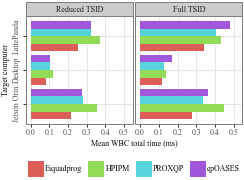

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.4 x 2.5 in image.
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: wbc_bars.pdf


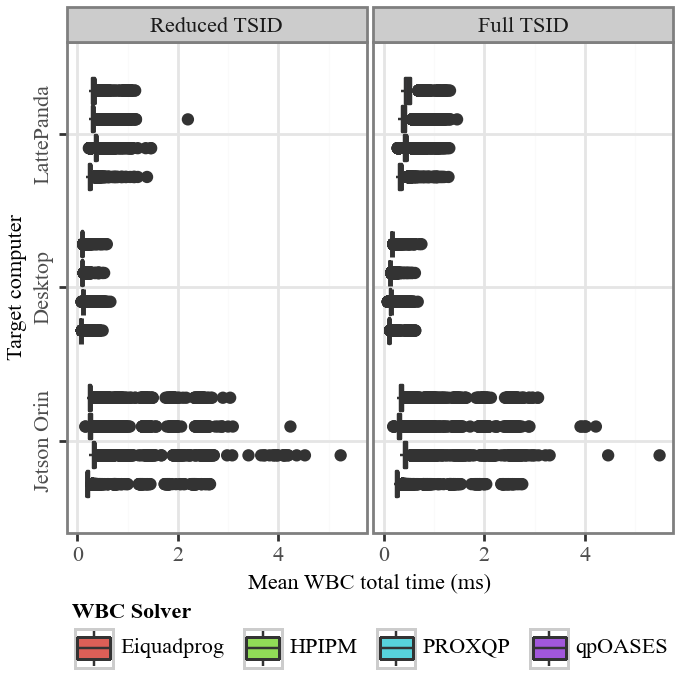

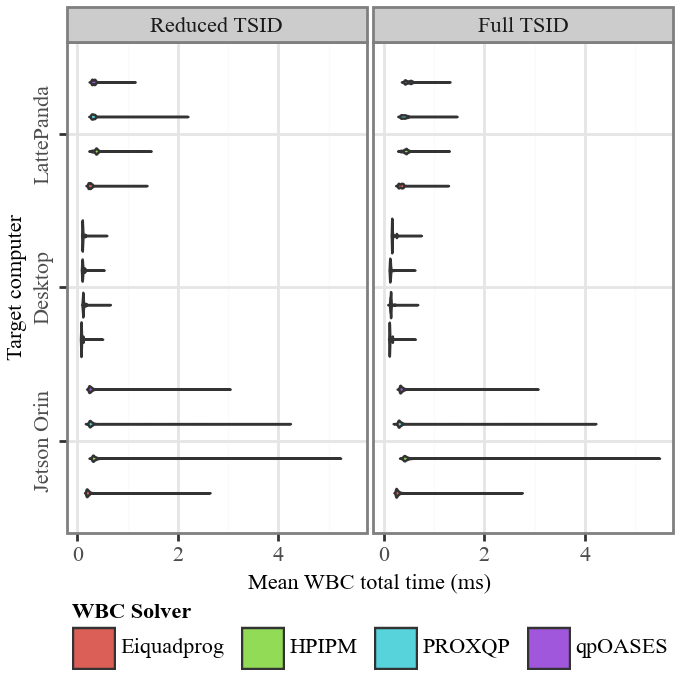

In [5]:


filtered_data = min_trail_data.loc[ 
                    (min_trail_data['experiment'] == "trot_exp") &
                    (min_trail_data['experiment_tag'].str.contains('wbc')) 
                    & (min_trail_data['N'] == "N20")
                    &~min_trail_data['failed']
                    ].melt(id_vars=group_keys, value_vars=["avg_wbc_total_time_ms"])

wbc_bars = (
 ggplot(filtered_data,
    aes(x="target_pc",y="value", fill='wbc_solver')) +
    p9.facet_grid(cols='wbc_scene', labeller=p9.labeller(cols=wbc_scene_beauty_map)) +
    p9.geom_bar(stat="identity", position = "dodge")
    +  p9.theme(figure_size=(16,4))
    + icra_style
    + leg_below
    + p9.scale_fill_discrete(labels=wbc_solver_beauty_map, name='')
    + p9.scale_x_discrete(labels=target_pc_beauty_map)
    + p9.ylab('Mean WBC total time (ms)')
    + p9.xlab('Target computer')
    + p9.guides(fill=p9.guide_legend(nrow=1, title=''))
    + p9.theme(axis_text_y=p9.element_text(rotation=90,vjust=0.5, hjust=1), figure_size=(icra_width, 2.5))
    + p9.coord_flip()
    + p9.ylim(0,0.52)

)

wbc_bars.show()
wbc_bars.save('wbc_bars.pdf')

filtered_data = data_wbc.loc[ 
                    (data_wbc['experiment'] == "trot_exp") &
                    (data_wbc['experiment_tag'].str.contains('wbc')) 
                    & (data_wbc['N'] == "N20")
                    &~data_wbc['failed']
                    ]

(
ggplot(filtered_data,
    aes(x="target_pc",y="wbc_total_time_ms", fill='wbc_solver')) +
    p9.facet_grid(cols='wbc_scene', labeller=p9.labeller(cols=wbc_scene_beauty_map)) +
    p9.geom_boxplot()
    +  p9.theme(figure_size=(16,4))
    + icra_style
    + leg_below
    + p9.scale_fill_discrete(labels=wbc_solver_beauty_map, name='WBC Solver')
    + p9.scale_x_discrete(labels=target_pc_beauty_map)
    + p9.ylab('Mean WBC total time (ms)')
    + p9.xlab('Target computer')
    + p9.guides(fill=p9.guide_legend(nrow=1))
    + p9.theme(axis_text_y=p9.element_text(rotation=90,vjust=0.5, hjust=1))
    + p9.coord_flip()
    

).show()

(
ggplot(filtered_data,
    aes(x="target_pc",y="wbc_total_time_ms", fill='wbc_solver')) +
    p9.facet_grid(cols='wbc_scene', labeller=p9.labeller(cols=wbc_scene_beauty_map)) +
    p9.geom_violin()
    +  p9.theme(figure_size=(16,4))
    + icra_style
    + leg_below
    + p9.scale_fill_discrete(labels=wbc_solver_beauty_map, name='WBC Solver')
    + p9.scale_x_discrete(labels=target_pc_beauty_map)
    + p9.ylab('Mean WBC total time (ms)')
    + p9.xlab('Target computer')
    + p9.guides(fill=p9.guide_legend(nrow=1))
    + p9.coord_flip()
    + p9.theme(axis_text_y=p9.element_text(rotation=90,vjust=0.5, hjust=1))

).show()








/tmp/ipykernel_90237/1258942970.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


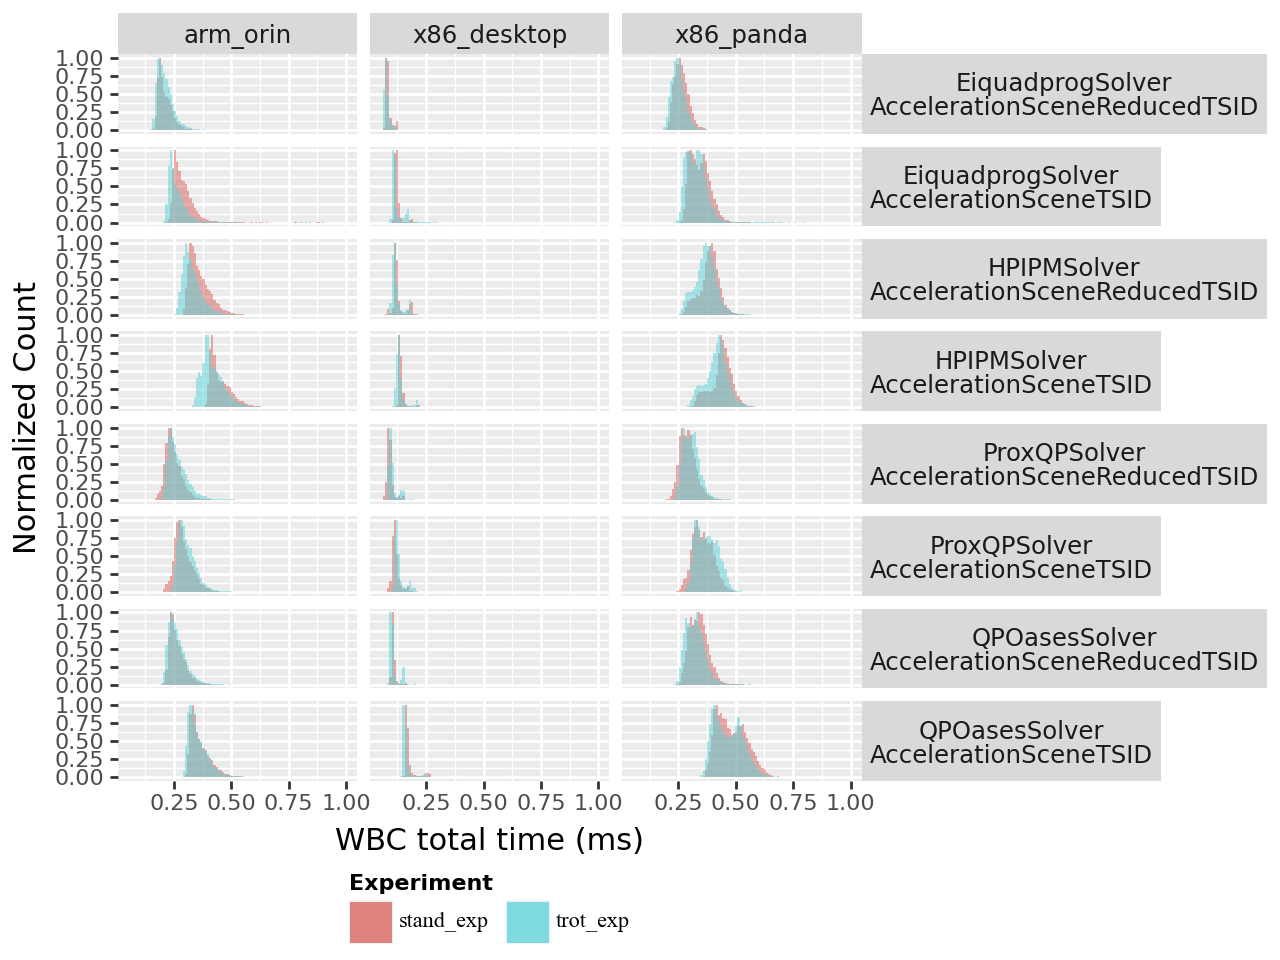

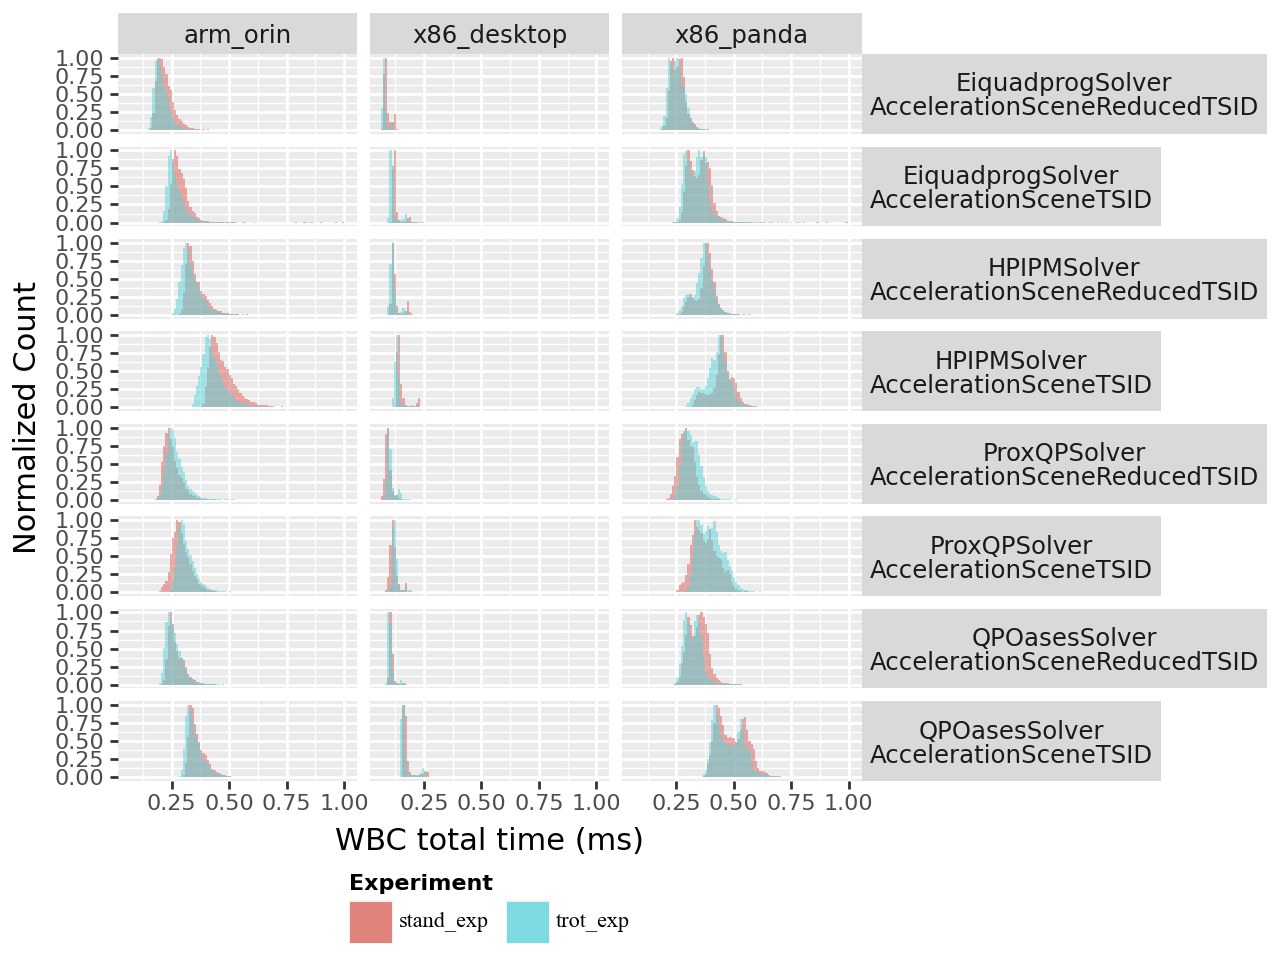

In [6]:
filtered_data = data_wbc.loc[ 
                            (data_wbc['experiment_tag'].str.contains('wbc'))
                           
                            ]

filtered_data.drop( filtered_data[(filtered_data['wbc_total_time_ms'] > 1.0)].index, inplace=True)

def hist(data):
        return(
                ggplot(data,
                        aes(x="wbc_total_time_ms",  fill="experiment", y=p9.after_stat('ncount')))
                        #+ p9.geom_density(aes(color="mpc_solver_cond", y=p9.after_stat("count*binwidth")),alpha=0.01, size=0.5)
                        + p9.facet_grid(cols="target_pc" ,rows=["wbc_solver", "wbc_scene"], 
                                        #labeller=p9.labeller(solver_name_beauty_map2)
                                        )
                        + p9.geom_histogram(data.loc[data['experiment'].str.contains('stand')],color="None", alpha=0.5, bins=100)
                        + p9.geom_histogram(data.loc[data['experiment'].str.contains('trot')],color="None", alpha=0.5, bins=100)
                        #+ icra_style
                        + leg_below
                        + p9.guides(fill=p9.guide_legend(ncol=4, title='Experiment'))
                        + p9.theme(axis_text_x=p9.element_text(rotation=0))
                        #+ p9.scale_fill_discrete(
                        #    labels=solver_name_beauty_map2
                        #)
                        #+ p9.scale_color_discrete(
                        #    labels=solver_name_beauty_map2
                        #)
                        #+p9.geom_vline(xintercept=0.01, color='red')
                        + p9.labs(x='WBC total time (ms)',y='Normalized Count')
                        #+  p9.geom_text()
                        + p9.theme(strip_text_y=p9.element_text(angle=0),axis_text=p9.element_text(size=8) )         
                        #+ p9.scale_y_log10()
                        #+ p9.scale_fill_discrete(labels={'stand_exp' : 'Standing', 'trot_exp' : 'Trotting'})
        )
hist(filtered_data.loc[filtered_data['N'] == "N10"]).show()
hist(filtered_data.loc[filtered_data['N'] == "N20"]).show()


/tmp/ipykernel_90237/960145508.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


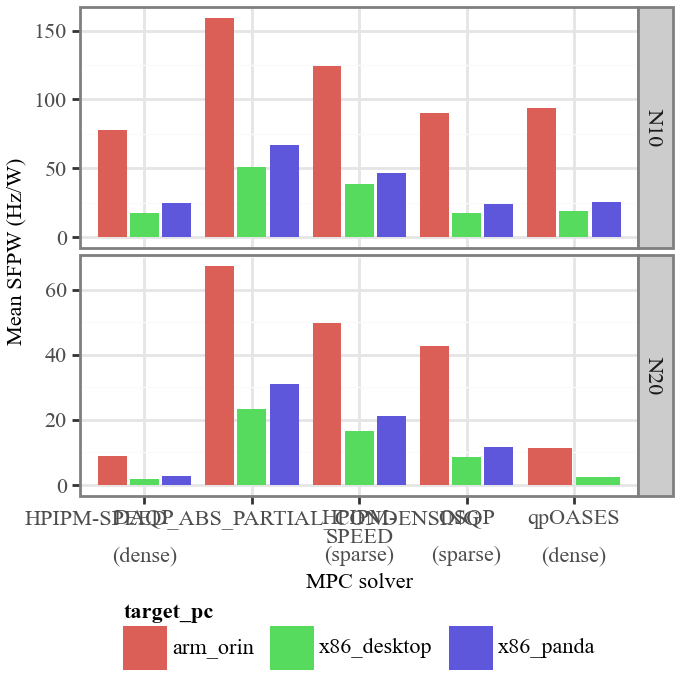

/tmp/ipykernel_90237/960145508.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_90237/960145508.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_90237/960145508.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dfki.uni-bremen.

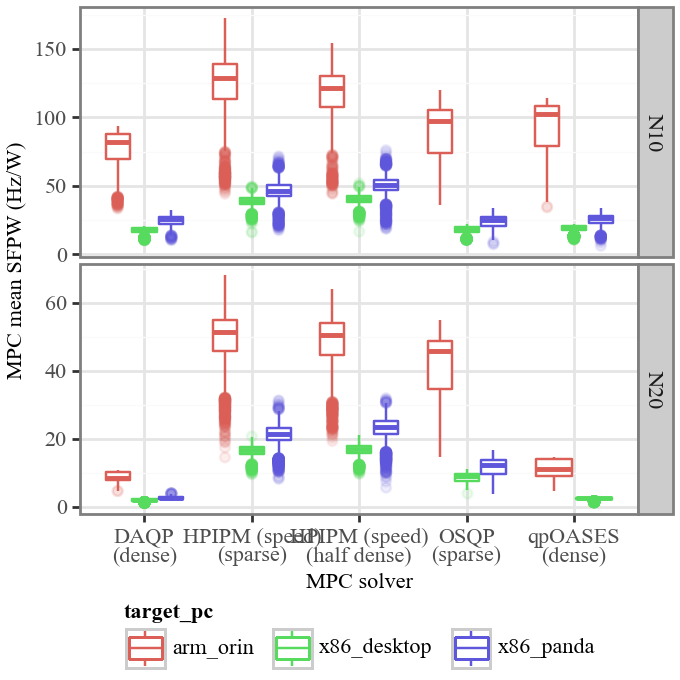

In [7]:
filtered_data = min_trail_data.loc[ 
                            ~(min_trail_data['failed']) &      
                            (((min_trail_data['N'] == "N10") &  (min_trail_data["cond_N"] == 10)) | ((min_trail_data['N'] == "N20") &  (min_trail_data["cond_N"] == 20)) | (min_trail_data["cond_type"] == "FULL_CONDENSING")) &
                            (min_trail_data['experiment'].str.contains('trot')) &
                            (~min_trail_data['experiment_tag'].str.contains('wbc') 
                             & ((min_trail_data['mpc_solver'].str.contains("SPEED")
                                 # &(~min_trail_data['mpc_solver'].str.contains("ABS"))
                                 )
                                 | (~min_trail_data['mpc_solver'].str.contains("HPIPM"))))
                            & ~((min_trail_data["cond_type"] == "FULL_CONDENSING") & min_trail_data['mpc_solver'].str.contains("HPIPM"))
                         ]#.melt(id_vars=group_keys, value_vars=["avg_mpc_sfpw", "avg_wbc_sfpw", "avg_watts"])
filtered_data["mpc_solver_cond"] = filtered_data["mpc_solver"] + "_" + filtered_data["cond_type"]

efficiency_plot = (
    ggplot(filtered_data,
            aes(x="mpc_solver_cond",y="avg_mpc_sfpw", fill="target_pc", label="experiment_tag", shape='experiment_tag')) +
            p9.facet_grid(rows='N', scales='free_y') +
            p9.geom_bar(stat="identity", position="dodge2")
            #+ p9.coord_flip()
            + icra_style
            + leg_below
            + p9.guides(fill=p9.guide_legend(ncol=3))
            + p9.theme(axis_text_x=p9.element_text(rotation=0))
            + p9.scale_x_discrete(
                labels=solver_name_beauty_map
            )
            + p9.labs(x='MPC solver', y='Mean SFPW (Hz/W)')
            #+  p9.geom_text()
)

efficiency_plot.show()


filtered_data = data_mpc.loc[ 
                            ~(data_mpc['failed']) &      
                                (
                                    ((data_mpc['N'] == "N10") &  (data_mpc["cond_N"] == 10)) | 
                                    ((data_mpc['N'] == "N20") &  (data_mpc["cond_N"] == 20)) | 
                                    (data_mpc["cond_type"] == "FULL_CONDENSING") |
                                    ((data_mpc["mpc_solver"].str.contains("HPIPM") & (data_mpc["N"] == "N10") & (data_mpc["cond_N"] == 5))) |
                                    ((data_mpc["mpc_solver"].str.contains("HPIPM") & (data_mpc["N"] == "N20") & (data_mpc["cond_N"] == 10)))
                                    
                                    ) &
                            (data_mpc['experiment'].str.contains('trot')) &
                            (~data_mpc['experiment_tag'].str.contains('wbc'))
                             & ((data_mpc['mpc_solver'].str.contains("SPEED") & (~data_mpc['mpc_solver'].str.contains("ABS")))| (~data_mpc['mpc_solver'].str.contains("HPIPM")))
                            & ~((data_mpc["cond_type"] == "FULL_CONDENSING") & data_mpc['mpc_solver'].str.contains("HPIPM"))
                         ]
filtered_data["mpc_solver_cond"] = filtered_data["mpc_solver"] + "_" + filtered_data["cond_type"]


filtered_data['N_numeric'] = filtered_data['N'].str.extract('(\d+)').astype(float)


filtered_data['mpc_solver_cond'] = filtered_data['mpc_solver'] + "_" + filtered_data['cond_type']

sel = filtered_data[filtered_data['cond_N'] == filtered_data['N_numeric'] / 2]

filtered_data.loc[sel.index, 'mpc_solver_cond'] =  filtered_data.loc[sel.index, 'mpc_solver_cond'] +'_H'

efficiency_plot = (
    ggplot(filtered_data,
            aes(x="mpc_solver_cond",y="mpc_sfpw", color="target_pc", label="experiment_tag")) +
            p9.facet_grid(rows='N', scales='free_y') +
            p9.geom_boxplot(outlier_alpha=0.1) 
            #+ p9.coord_flip()
            + icra_style
            + leg_below
            + p9.guides(color=p9.guide_legend(ncol=3))
            + p9.theme(axis_text_x=p9.element_text(rotation=0))
            + p9.scale_x_discrete(
                labels=solver_name_beauty_map2
            )
            + p9.labs(x='MPC solver', y='MPC mean SFPW (Hz/W)')
            #+  p9.geom_text()
)

efficiency_plot.save("efficiency.pdf")
efficiency_plot.show()



/tmp/ipykernel_90237/2634067346.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_90237/2634067346.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



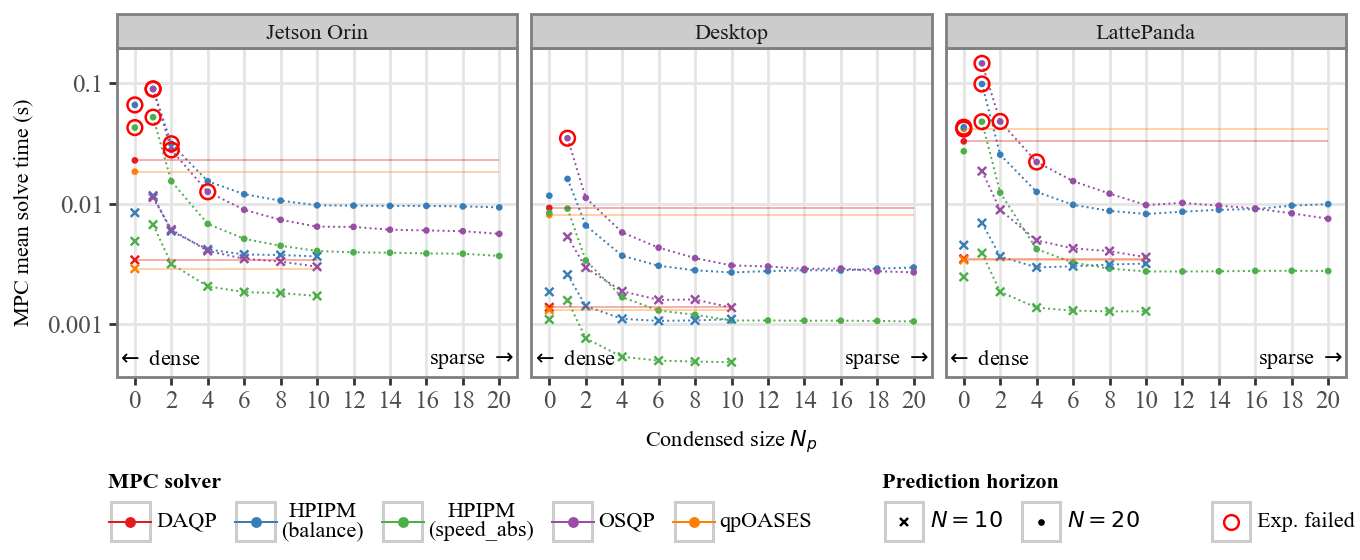

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.8 x 2.8 in image.
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: solve_time.pdf
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



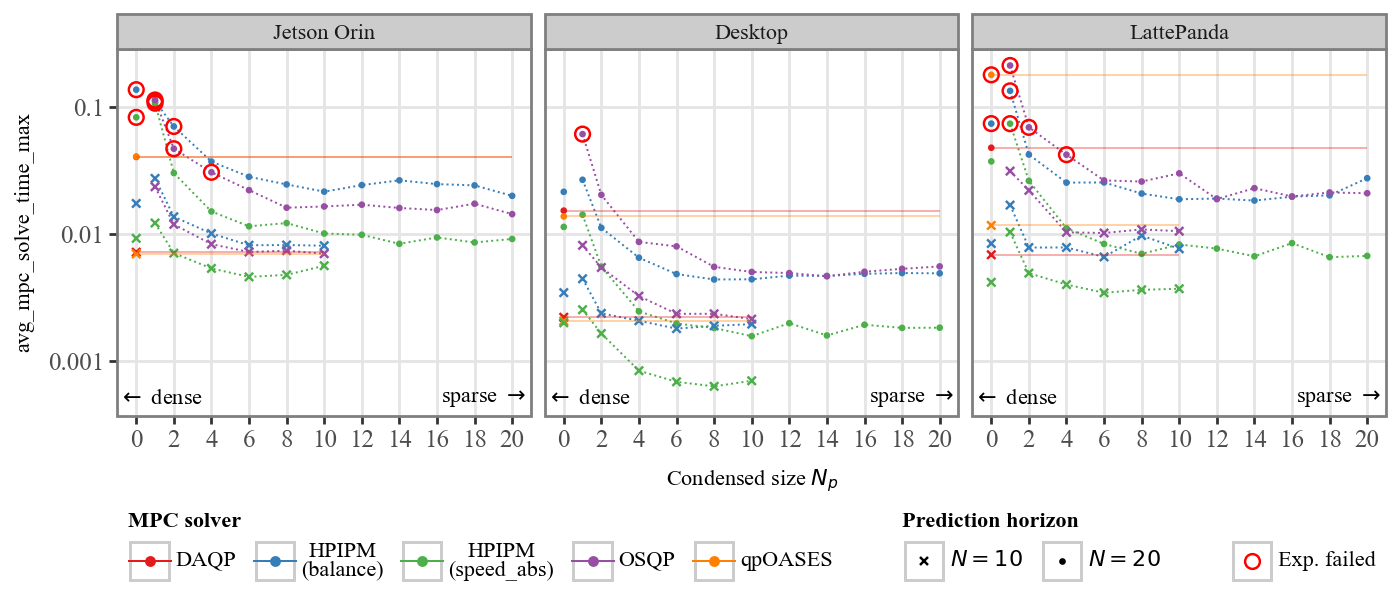

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


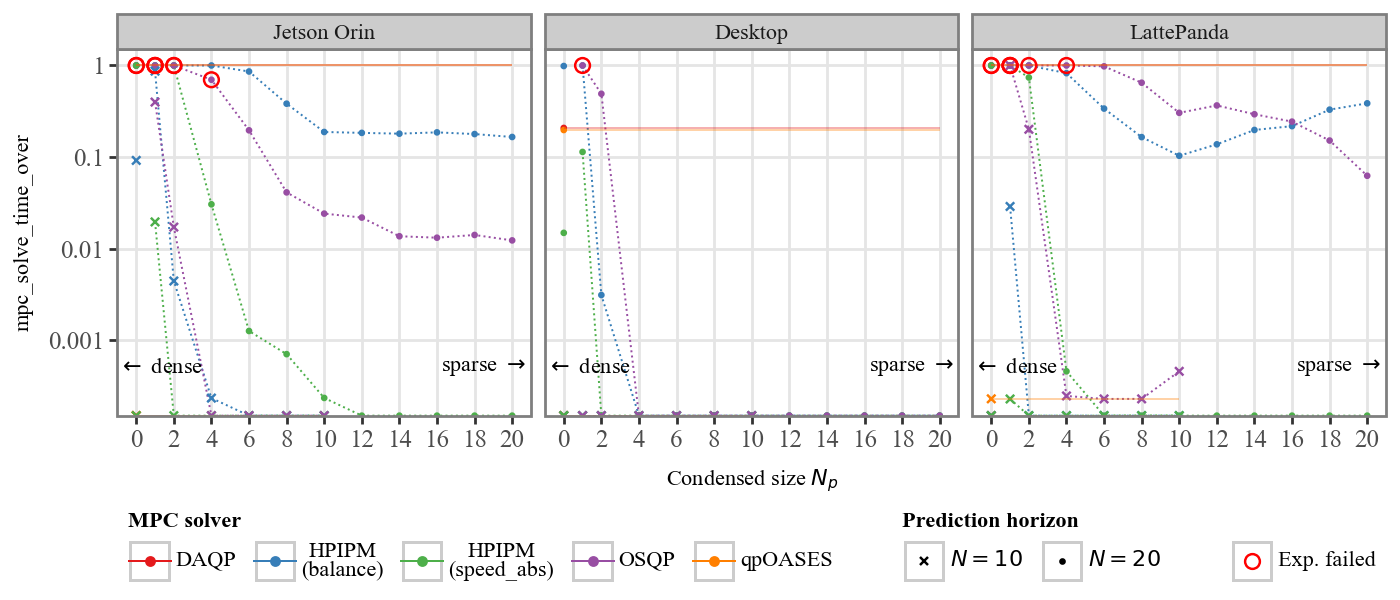

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



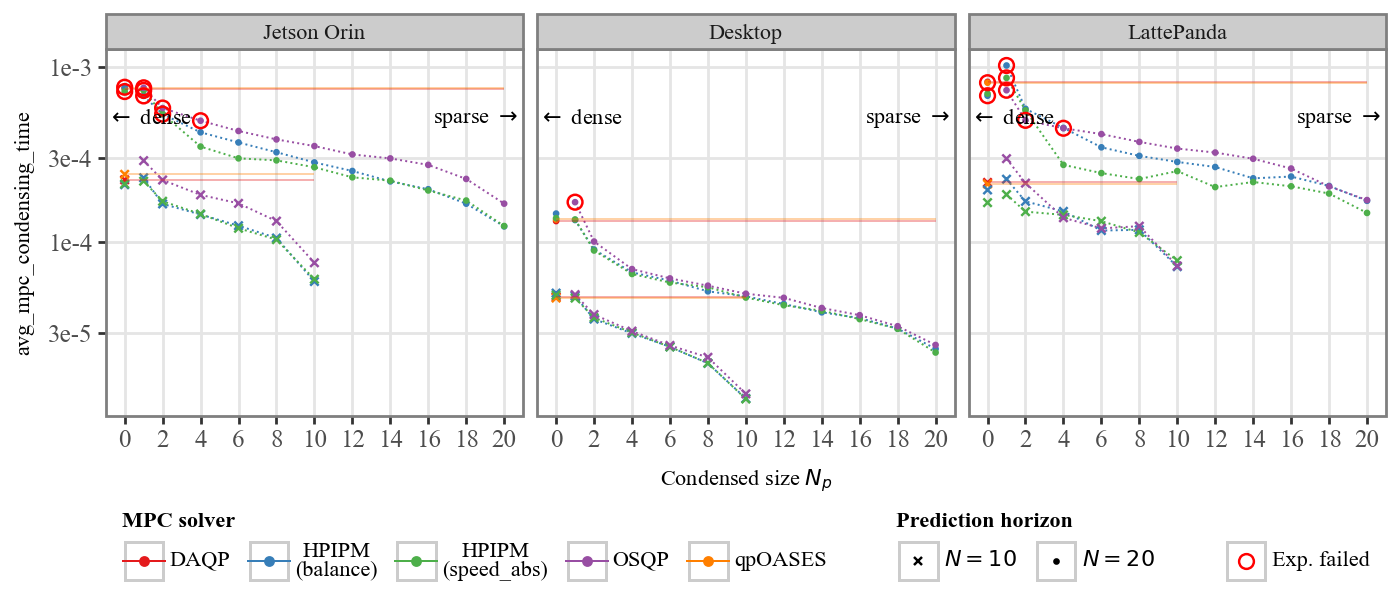

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



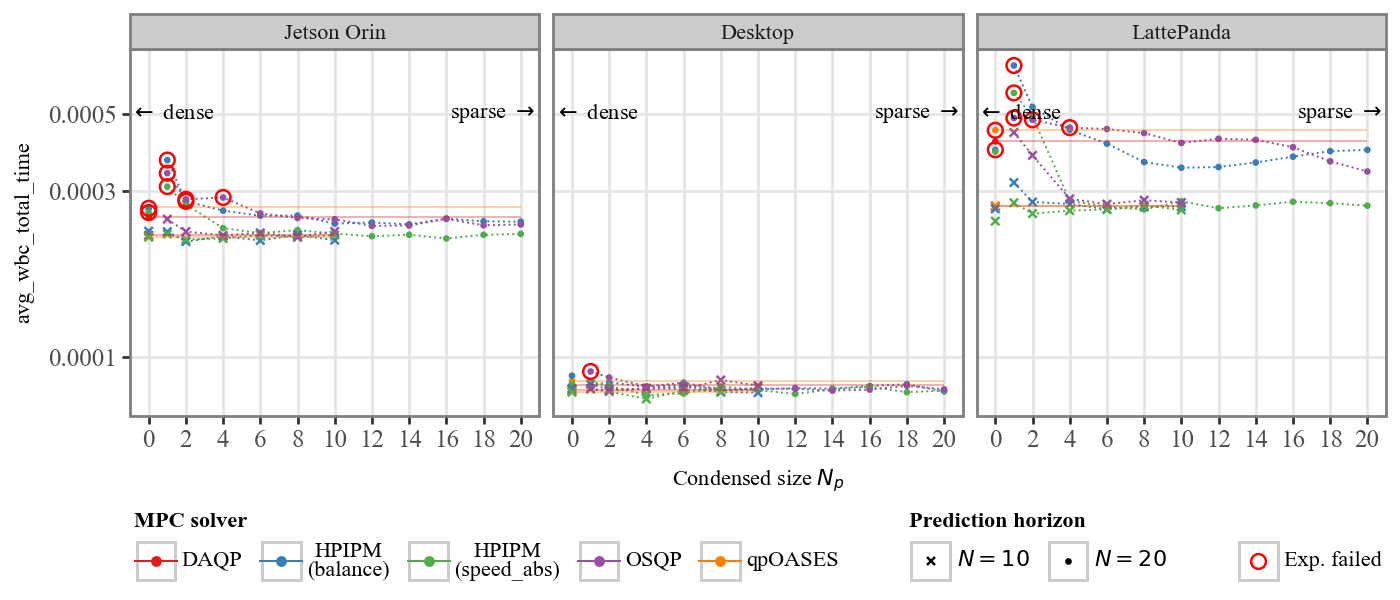

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 3.0 in image.
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: efficiency_big_plot.pdf


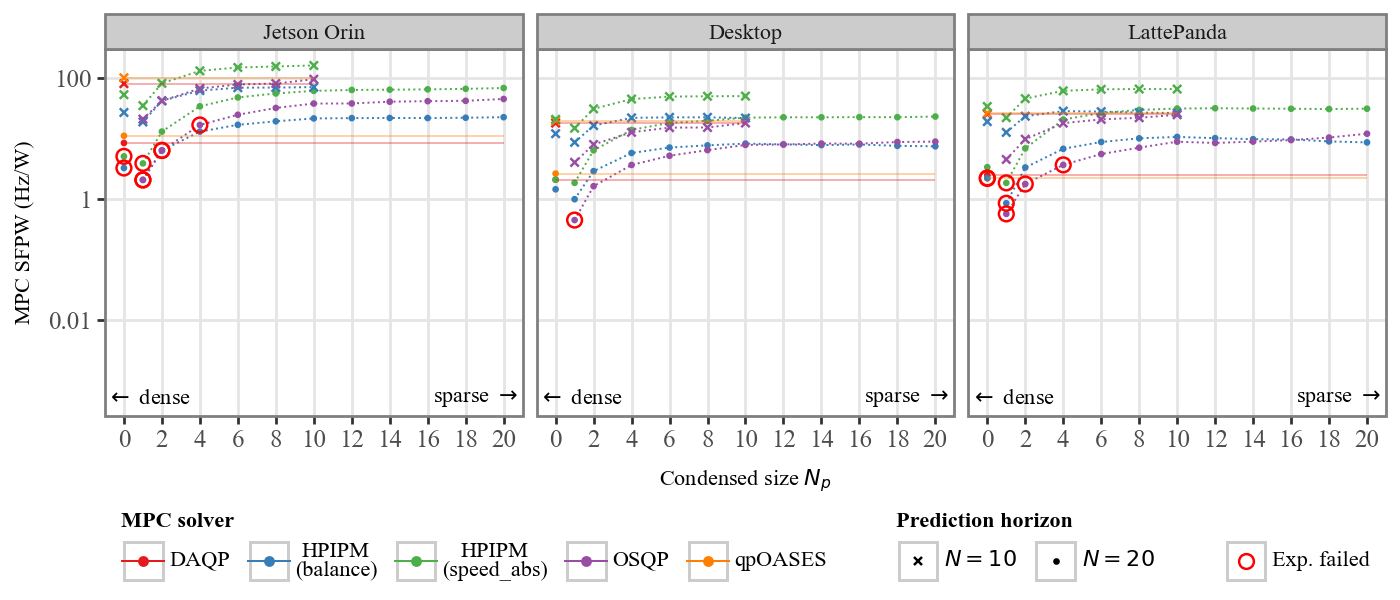

In [8]:

def plot_entity_per_solver(entity: str, data, group_by="N", rows_by='experiment'):
    return (
       ggplot(data, 
              aes(x="cond_N", y=entity, color="mpc_solver", shape=group_by, linetype="cond_type")) 
              +  p9.facet_grid(cols='target_pc', labeller=p9.labeller(cols=target_pc_beauty_map))
              +  p9.geom_line(size=0.4)
              +  p9.geom_point(size=1.2)
              +  p9.geom_segment(data = data.loc[(data["cond_type"].str.contains('FULL')) & ~(data["mpc_solver"].str.contains('HPIPM'))], mapping=aes(y=entity, yend=entity, color='mpc_solver',linetype="cond_type", xend='N_clean'), x=0, alpha=0.35, size=0.4)
              +  p9.geom_point(data = data.loc[data['failed']], color='red', shape='o', mapping=aes(y=entity, x='cond_N', size='failed'), fill='None')
              +  icra_style_double_col
              +  leg_below
              +  p9.scale_x_continuous(breaks = (0,2,4,6,8,10,12,14,16,18,20))
              +  p9.scale_y_log10()
              +  p9.theme(axis_text=p9.element_text(size=9))
              +  p9.labs(color="MPC solver", fill="MPC solver", linetype="Condensing type", shape="Prediction horizon", x="Condensed size $N_p$")
              +  p9.scale_size_manual(
                  name=" ",
                  values={True: 2.5, False: 0}, 
                  labels={True: "Exp. failed", False:""}
               )
               + p9.scale_linetype_manual({"PARTIAL_CONDENSING" : 'dotted', "FULL_CONDENSING" : 'solid'}, labels=cond_name_beauty_map)
               + p9.scale_color_discrete(labels=solver_onlyname_beauty_map)
               + p9.scale_color_brewer(type='qualitative', palette=6, labels=solver_onlyname_beauty_map)
               + p9.scale_shape_manual({'N10' : 'x', 'N20' : '.'}, labels={'N10' : '$N=10$', 'N20' : '$N=20$'})
               + p9.scale_fill_discrete(labels=solver_onlyname_beauty_map)
               + p9.guides(color=p9.guide_legend(order=1, ncol=5), linetype=False, shape=p9.guide_legend(order=3, nrow=1), size=p9.guide_legend(order=4))
               + p9.annotate("text", x=18.5, y=0.0005, label='sparse $\\rightarrow$', size=8, color='black')
               + p9.annotate("text", x=1.3, y=0.0005, label='$\leftarrow$ dense', size=8, color='black')
               + p9.theme(panel_grid_minor=p9.element_blank())
            
            
   )


filtered_data =  min_trail_data.loc[
                            (min_trail_data['experiment'] == "trot_exp") &
                            (~min_trail_data['experiment_tag'].str.contains('wbc')) &
                            (min_trail_data['wbc_solver'] == "EiquadprogSolver") &
                            ((min_trail_data['mpc_solver'].str.contains('HPIPM')) & (
                                 min_trail_data['mpc_solver'].str.contains("BALANCE") |
                                 min_trail_data['mpc_solver'].str.contains("SPEED_ABS") 
                            ) |   ~(min_trail_data['mpc_solver'].str.contains('HPIPM')))
                             #&(((min_trail_data['mpc_solver'].str.contains("SPEED") #& (~min_trail_data['mpc_solver'].str.contains("ABS"))
                              # )
                              #| (~min_trail_data['mpc_solver'].str.contains("HPIPM"))
                              #|  (min_trail_data['mpc_solver'].str.contains("HPIPM"))
                              #))
                              #| (min_trail_data['mpc_solver'].str.contains("BALANCE"))
                              
                         ]



filtered_data["more_than_one_trial"] = filtered_data["trial"].apply(lambda x : x > 1)

filtered_data["cond_N"] = filtered_data[["cond_N", "cond_type"]].apply(lambda row: 0 if row["cond_type"] == "FULL_CONDENSING" else row["cond_N"], axis=1)
filtered_data = filtered_data.loc[(filtered_data['cond_N'] % 2 == 0) | (filtered_data['cond_N'] == 1) ]
filtered_data['N_clean'] = filtered_data["N"].apply(lambda x : float(x.split("N")[1]))

solve_time_plots = (plot_entity_per_solver("avg_mpc_total_time",filtered_data)
 #+ p9.geom_ribbon(mapping=aes(ymin="avg_mpc_solve_time_q25", ymax="avg_mpc_solve_time_q75", fill='mpc_solver'), alpha=0.2, linetype='None')
 #+ p9.geom_rect(data = filtered_data.loc[(filtered_data["cond_type"].str.contains('FULL'))], 
 #               mapping=aes(ymin="avg_mpc_solve_time_q25", ymax="avg_mpc_solve_time_q75", fill='mpc_solver'), alpha=0.2, color='None', xmin=1, xmax=20)
 + p9.labs(y="MPC mean solve time (s)")
 + p9.theme(figure_size=(icra_width * 2, 2.8))
 )
solve_time_plots.show()
solve_time_plots.save("solve_time.pdf")
plot_entity_per_solver("avg_mpc_solve_time_max",filtered_data).show()
plot_entity_per_solver("mpc_solve_time_over",filtered_data).show()
plot_entity_per_solver("avg_mpc_condensing_time",filtered_data).show()
plot_entity_per_solver("avg_wbc_total_time",filtered_data).show()
efficiency_big_plots = (plot_entity_per_solver("avg_mpc_sfpw_median",filtered_data)
                        #+ p9.geom_ribbon(mapping=aes(ymin="avg_mpc_sfpw_q25", ymax="avg_mpc_sfpw_q75", fill='mpc_solver'), alpha=0.2, linetype='None')
                        #+ p9.geom_rect(data = filtered_data.loc[(filtered_data["cond_type"].str.contains('FULL'))], 
                        #               mapping=aes(ymin="avg_mpc_sfpw_q25", ymax="avg_mpc_sfpw_q75", fill='mpc_solver'), alpha=0.2, color='None', xmin=1, xmax=20)
                        + p9.labs(y="MPC SFPW (Hz/W)")
                       
                       )
efficiency_big_plots.save('efficiency_big_plot.pdf')
efficiency_big_plots.show()
#plot_entity_per_solver("avg_wbc_sfpw",filtered_data).show()


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)




In [9]:
gk = group_keys.copy()
gk.remove('cond_N')
minidx = filtered_data.loc[(filtered_data['N'] == 'N10')].groupby(gk)['avg_mpc_solve_time'].idxmin()


filtered_data.loc[minidx][filtered_data['target_pc'].str.contains('panda')].sort_values('avg_mpc_solve_time')[["mpc_solver","cond_type","cond_N","avg_mpc_solve_time","avg_mpc_sfpw"]]

/tmp/ipykernel_90237/4283914946.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,mpc_solver,cond_type,cond_N,avg_mpc_solve_time,avg_mpc_sfpw
1080,HPIPM-SPEED_ABS,PARTIAL_CONDENSING,8.0,0.001155,66.760870
1055,HPIPM-SPEED_ABS,FULL_CONDENSING,0.0,0.002288,34.713359
1142,HPIPM-BALANCE,PARTIAL_CONDENSING,4.0,0.002798,28.968582
1138,QPOASES,FULL_CONDENSING,0.0,0.003056,25.333724
1112,DAQP,FULL_CONDENSING,0.0,0.003126,24.697239
1122,OSQP,PARTIAL_CONDENSING,10.0,0.003432,24.218334
1053,HPIPM-BALANCE,FULL_CONDENSING,0.0,0.004314,19.598250


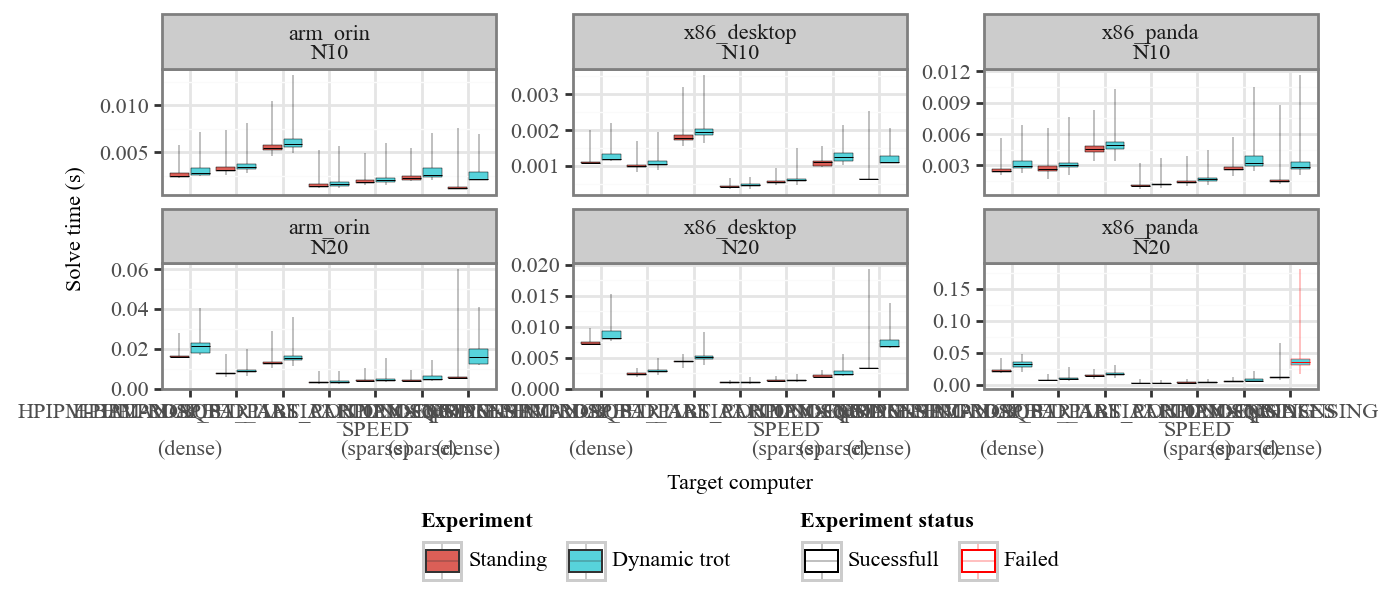

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 3.0 in image.
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: variance.pdf


In [12]:
filtered_data = min_trail_data.loc[ 
                            ~(min_trail_data['experiment_tag'].str.contains('wbc'))
                            & (((min_trail_data['N'] == "N10") &  (min_trail_data["cond_N"] == 10)) | ((min_trail_data['N'] == "N20") &  (min_trail_data["cond_N"] == 20)) | (min_trail_data["cond_type"] == "FULL_CONDENSING")) 
                         ]#.melt(id_vars=group_keys, value_vars=["avg_mpc_sfpw", "avg_wbc_sfpw"])
filtered_data = filtered_data.loc[ ~((filtered_data["cond_type"] == "FULL_CONDENSING") & filtered_data['mpc_solver'].str.contains("HPIPM"))]
filtered_data["mpc_solver_cond"] = filtered_data["mpc_solver"] + "_" + filtered_data["cond_type"]
p9.geoms.geom_boxplot.DEFAULT_AES['size'] = 0.1

variance_plot = (
    ggplot(filtered_data,
            aes(x="mpc_solver_cond",
                ymin = "avg_mpc_solve_time_min",
                lower = "avg_mpc_solve_time_q25",
                middle = "avg_mpc_solve_time_median",
                upper = "avg_mpc_solve_time_q75",
                ymax = "avg_mpc_solve_time_max",
                fill="experiment", color="failed")) +
            p9.facet_wrap(['target_pc', 'N'],scales="free_y", dir='v')
            #p9.geom_bar(stat="identity", position="dodge2")
            +  p9.geom_boxplot(stat="identity")
            +  p9.theme(figure_size=(20,10),
            axis_text_x=p9.element_text(rotation=0))
            + p9.labs(x='Target computer', y='Solve time (s)', fill='Experiment')
            + p9.scale_fill_discrete(labels={'stand_exp':'Standing', 'trot_exp':'Dynamic trot'})
            #+ p9.scale_y_log10()
            + icra_style_double_col
            + leg_below
            + p9.guides(fill=p9.guide_legend(nrow=1), color=p9.guide_legend(nrow=1))
            + p9.scale_x_discrete(
                labels=solver_name_beauty_map
            )
            + p9.scale_color_manual({True:'red', False:'black'},labels={True:'Failed', False:'Sucessfull'}, name="Experiment status")
)

variance_plot.show()
variance_plot.save('variance.pdf')



In [ ]:
filtered_data = data_mpc.loc[ 
                            ~(data_mpc['failed']) &      
                                (
                                    ((data_mpc['N'] == "N10") &  (data_mpc["cond_N"] == 10)) | 
                                    ((data_mpc['N'] == "N20") &  (data_mpc["cond_N"] == 20)) | 
                                    (data_mpc["cond_type"] == "FULL_CONDENSING") |
                                    ((data_mpc["mpc_solver"].str.contains("HPIPM") & (data_mpc["N"] == "N10") & (data_mpc["cond_N"] == 5))) |
                                    ((data_mpc["mpc_solver"].str.contains("HPIPM") & (data_mpc["N"] == "N20") & (data_mpc["cond_N"] == 10)))
                                    
                                    ) &

                                                                ((data_mpc['mpc_solver'].str.contains('HPIPM')) & (data_mpc["cond_type"] == "PARTIAL_CONDENSING") & (
                                 data_mpc['mpc_solver'].str.contains("BALANCE") |
                                 data_mpc['mpc_solver'].str.contains("SPEED_ABS") 
                            ) |   ~(data_mpc['mpc_solver'].str.contains('HPIPM'))) &
                            (data_mpc['experiment'].str.contains('trot')) &
                            (~data_mpc['experiment_tag'].str.contains('wbc'))
        
                         ]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

filtered_data.groupby(group_keys)["mpc_solve_time"].describe()



count  \
target_pc   experiment_tag             N   mpc_solver      cond_type          wbc_solver       cond_N experiment wbc_scene                              
arm_orin    all_solvers_new_20240826   N10 DAQP            FULL_CONDENSING    EiquadprogSolver 1.0    trot_exp   AccelerationSceneReducedTSID  4292.0   
                                           HPIPM-BALANCE   PARTIAL_CONDENSING EiquadprogSolver 5.0    trot_exp   AccelerationSceneReducedTSID  4290.0   
                                                                                               10.0   trot_exp   AccelerationSceneReducedTSID  3996.0   
                                           HPIPM-SPEED_ABS PARTIAL_CONDENSING EiquadprogSolver 5.0    trot_exp   AccelerationSceneReducedTSID  3993.0   
                                                                                               10.0   trot_exp   AccelerationSceneReducedTSID  4282.0   
                                           OSQP            PARTIAL_CONDENSING EiquadprogSolver 10.0   trot_exp   AccelerationSceneReducedTSID  3992.0   
                                           QPOASES         FULL_CONDENSING    EiquadprogSolver 1.0    trot_exp   AccelerationSceneReducedTSID  4244.0   
                                       N20 DAQP            FULL_CONDENSING    EiquadprogSolver 1.0    trot_exp   AccelerationSceneReducedTSID  1807.0   
                                           HPIPM-BALANCE   PARTIAL_CONDENSING EiquadprogSolver 10.0   trot_exp   AccelerationSceneReducedTSID  3834.0   
                                                                                               20.0   trot_exp   AccelerationSceneReducedTSID  4167.0   
                                           HPIPM-SPEED_ABS PARTIAL_CONDENSING EiquadprogSolver 10.0   trot_exp   AccelerationSceneReducedTSID  4250.0   
                                                                                               20.0   trot_exp   AccelerationSceneReducedTSID  4239.0   
                                           OSQP            PARTIAL_CONDENSING EiquadprogSolver 20.0   trot_exp   AccelerationSceneReducedTSID  4297.0   
                                           QPOASES         FULL_CONDENSING    EiquadprogSolver 1.0    trot_exp   AccelerationSceneReducedTSID  2242.0   
x86_desktop all_solvers_new_20240826   N10 DAQP            FULL_CONDENSING    EiquadprogSolver 1.0    trot_exp   AccelerationSceneReducedTSID  4159.0   
                                           HPIPM-BALANCE   PARTIAL_CONDENSING EiquadprogSolver 5.0    trot_exp   AccelerationSceneReducedTSID  4159.0   
                                                                                               10.0   trot_exp   AccelerationSceneReducedTSID  4100.0   
                                           HPIPM-SPEED_ABS PARTIAL_CONDENSING EiquadprogSolver 5.0    trot_exp   AccelerationSceneReducedTSID  4159.0   
                                                                                               10.0   trot_exp   AccelerationSceneReducedTSID  4109.0   
                                           OSQP            PARTIAL_CONDENSING EiquadprogSolver 10.0   trot_exp   AccelerationSceneReducedTSID  4159.0   
                                           QPOASES         FULL_CONDENSING    EiquadprogSolver 1.0    trot_exp   AccelerationSceneReducedTSID  4149.0   
                                       N20 DAQP            FULL_CONDENSING    EiquadprogSolver 1.0    trot_exp   AccelerationSceneReducedTSID  4108.0   
                                           HPIPM-BALANCE   PARTIAL_CONDENSING EiquadprogSolver 10.0   trot_exp   AccelerationSceneReducedTSID  4109.0   
                                                                                               20.0   trot_exp   AccelerationSceneReducedTSID  4159.0   
                                           HPIPM-SPEED_ABS PARTIAL_CONDENSING EiquadprogSolver 10.0   trot_exp   AccelerationSceneReducedTSID  4109.0   
             

/tmp/ipykernel_24872/3038241518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_24872/3038241518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


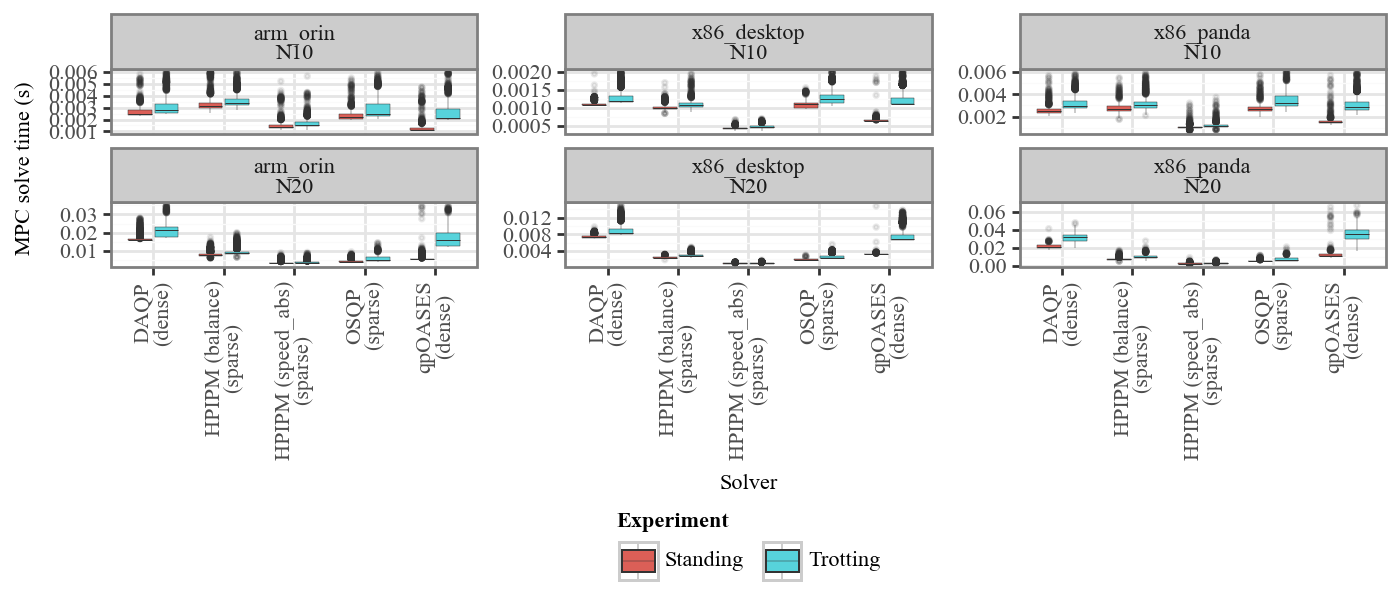

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 3.0 in image.
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: mpc_variance_new.pdf


In [ ]:


filtered_data['N_numeric'] = filtered_data['N'].str.extract('(\d+)').astype(float)


filtered_data['mpc_solver_cond'] = filtered_data['mpc_solver'] + "_" + filtered_data['cond_type']

sel = filtered_data[filtered_data['cond_N'] == filtered_data['N_numeric'] / 2]

filtered_data.loc[sel.index, 'mpc_solver_cond'] =  filtered_data.loc[sel.index, 'mpc_solver_cond'] +'_H'

p9.geoms.geom_boxplot.DEFAULT_AES['size'] = 0.1

variance_plot = (
    ggplot(filtered_data,
            aes(x="mpc_solver_cond",
                y = "mpc_solve_time",
                #color="failed",
                fill="experiment")) +
            p9.facet_wrap(['target_pc', 'N'],scales="free_y", dir='v')
            +  p9.geom_boxplot(outlier_alpha=0.1, outlier_size=0.5)
            +  p9.theme(figure_size=(20,10),
            axis_text_x=p9.element_text(rotation=0))
            + p9.labs(x='Solver', y='MPC solve time (s)', fill='Experiment')
            + p9.scale_fill_discrete(labels={'stand_exp':'Standing', 'trot_exp':'Trotting'})
            #+ p9.scale_y_log10()
            + icra_style_double_col
            + leg_below
            + p9.guides(fill=p9.guide_legend(nrow=1), color=p9.guide_legend(nrow=1))
            + p9.scale_x_discrete(
                labels=solver_name_beauty_map2
            )
            + p9.theme(axis_text_x=p9.element_text(size=8.0, angle=90))
            #+ p9.scale_color_manual({True:'red', False:'black'},labels={True:'Failed', False:'Sucessfull'}, name="Experiment status")
)

variance_plot.show()
variance_plot.save('mpc_variance_new.pdf')




/tmp/ipykernel_136902/3399443487.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_136902/3399443487.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_136902/3399443487.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_136902/3399443487.py:38: SettingWithCopyWarning: 
A value 

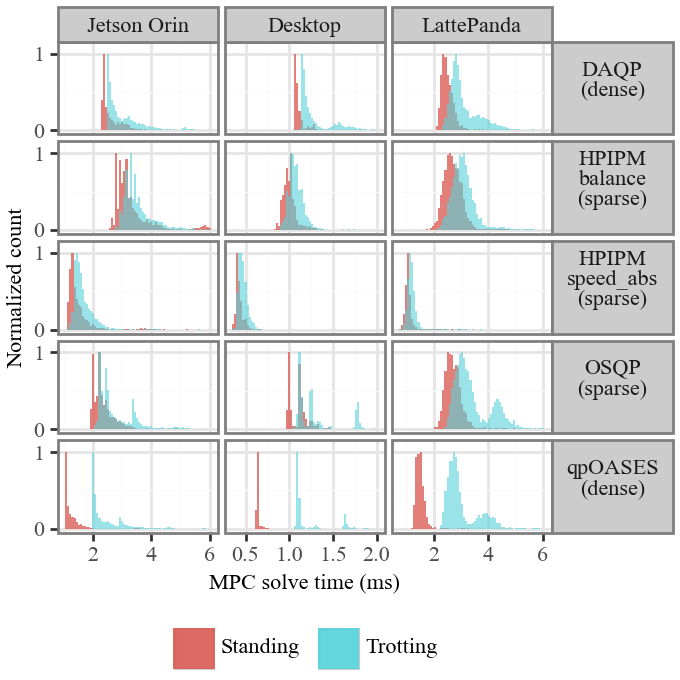

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


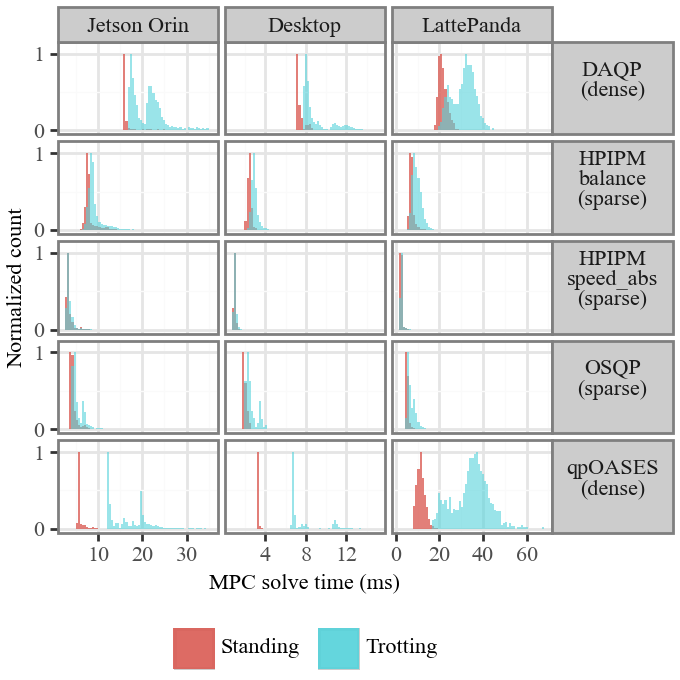

/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.4 x 3.4 in image.
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: mpc_hist_n10.pdf
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.4 x 3.4 in image.
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: mpc_hist_n20.pdf
/home/dfki.uni-bremen.de/fstark/.local/lib/python3.10/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [ ]:
filtered_data = data_mpc.loc[ 
                            #~(data_mpc['failed']) &      
                                (
                                    ((data_mpc['N'] == "N10") &  (data_mpc["cond_N"] == 10)) | 
                                    ((data_mpc['N'] == "N20") &  (data_mpc["cond_N"] == 20)) | 
                                    (data_mpc["cond_type"] == "FULL_CONDENSING") 
                                    #|
                                    #((data_mpc["mpc_solver"].str.contains("HPIPM") & (data_mpc["N"] == "N10") & (data_mpc["cond_N"] == 5))) |
                                    #((data_mpc["mpc_solver"].str.contains("HPIPM") & (data_mpc["N"] == "N20") & (data_mpc["cond_N"] == 10)))
                                    
                                    ) &
                            #(data_mpc['experiment'].str.contains('trot')) &
                            (~data_mpc['experiment_tag'].str.contains('wbc'))& 
                            ((data_mpc['mpc_solver'].str.contains('HPIPM')) & (data_mpc["cond_type"] == "PARTIAL_CONDENSING") & (
                                 data_mpc['mpc_solver'].str.contains("BALANCE") |
                                 data_mpc['mpc_solver'].str.contains("SPEED_ABS") 
                            ) |   ~(data_mpc['mpc_solver'].str.contains('HPIPM')))
                         ]

filtered_data['N_numeric'] = filtered_data['N'].str.extract('(\d+)').astype(float)


filtered_data['mpc_solver_cond'] = filtered_data['mpc_solver'] + "_" + filtered_data['cond_type']

sel = filtered_data[filtered_data['cond_N'] == filtered_data['N_numeric'] / 2]

filtered_data.loc[sel.index, 'mpc_solver_cond'] =  filtered_data.loc[sel.index, 'mpc_solver_cond'] +'_H'



# This is to imrpove visualisation: manual inspection that there it wont change the plot, but just zooms in to the areas we are intersted in:
filtered_data.drop(filtered_data[
    (filtered_data['N'] == "N10") &
    (filtered_data['target_pc'] == "x86_desktop") &
    (filtered_data['mpc_solve_time_ms'] > 2.0)
].index, inplace=True)

filtered_data.drop(filtered_data[
    (filtered_data['N'] == "N10") &
    (filtered_data['target_pc'] == "arm_orin") &
    (filtered_data['mpc_solve_time_ms'] > 6.0)
].index, inplace=True)


filtered_data.drop(filtered_data[
    (filtered_data['N'] == "N10") &
    (filtered_data['target_pc'] == "x86_panda") &
    (filtered_data['mpc_solve_time_ms'] > 6.0)
].index, inplace=True)

filtered_data.drop(filtered_data[
    (filtered_data['N'] == "N20") &
    (filtered_data['target_pc'] == "x86_desktop") &
    (filtered_data['mpc_solve_time_ms'] > 15.0)
].index, inplace=True)

filtered_data.drop(filtered_data[
    (filtered_data['N'] == "N20") &
    (filtered_data['target_pc'] == "arm_orin") &
    (filtered_data['mpc_solve_time_ms'] > 35.0)
].index, inplace=True)


filtered_data.drop(filtered_data[
    (filtered_data['N'] == "N20") &
    (filtered_data['target_pc'] == "x86_panda") &
    (filtered_data['mpc_solve_time_ms'] > 75.0)
].index, inplace=True)

add_blank = '\n                   '

solver_name_beauty_map2_hack = {
                    'DAQP_FULL_CONDENSING' :                'DAQP\n(dense)' + add_blank,
                    'QPOASES_FULL_CONDENSING' :             'qpOASES\n(dense)' + add_blank,
                    'HPIPM-SPEED_FULL_CONDENSING' :         'HPIPM (speed)\n(dense)' + add_blank,
                    'OSQP_PARTIAL_CONDENSING' :             'OSQP\n(sparse)' + add_blank,
                    'HPIPM-SPEED_PARTIAL_CONDENSING' :      'HPIPM (speed)\n(sparse)' + add_blank,
                    'HPIPM-SPEED_PARTIAL_CONDENSING_H' :    'HPIPM (speed)\n(half dense)' + add_blank,
                    'HPIPM-SPEED_ABS_PARTIAL_CONDENSING' :  'HPIPM\nspeed_abs\n(sparse)' + add_blank,
                    'HPIPM-SPEED_ABS_PARTIAL_CONDENSING_H' :'HPIPM (speed_abs)\n(half dense)' + add_blank,
                    'HPIPM-BALANCE_PARTIAL_CONDENSING' :    'HPIPM\nbalance\n(sparse)' + add_blank,
                    'HPIPM-BALANCE_PARTIAL_CONDENSING_H' :  'HPIPM (balance)\n(half dense)' + add_blank,
                }



def eff_hist(data,binwidth, max):
    bins = 70
    return (
        ggplot(data,
                aes(x="mpc_solve_time_ms",  fill="experiment", y=p9.after_stat('ncount')))
                #+ p9.geom_density(aes(color="mpc_solver_cond", y=p9.after_stat("count*binwidth")),alpha=0.01, size=0.5)
                + p9.facet_grid(cols="target_pc",  scales='free', rows="mpc_solver_cond", labeller=p9.labeller(solver_name_beauty_map2_hack, cols=target_pc_beauty_map))
                + p9.geom_histogram(data.loc[data['experiment'] == 'stand_exp'],color="None", alpha=0.8, bins=bins)
                + p9.geom_histogram(data.loc[data['experiment'] == 'trot_exp'],color="None", alpha=0.6, bins=bins)
                + icra_style
                + leg_below
                + p9.guides(fill=p9.guide_legend(ncol=4, title=''))
                + p9.theme(axis_text_x=p9.element_text(rotation=0))
                + p9.scale_fill_discrete(
                    labels=solver_name_beauty_map2_hack
                )
                + p9.scale_color_discrete( 
                    labels=solver_name_beauty_map2_hack
                )
                #+p9.geom_vline(xintercept=0.01, color='red')
                + p9.labs(x='MPC solve time (ms)',y='Normalized count')
                #+ p9.xlim(0, max)
                #+  p9.geom_text()
                + p9.theme(strip_text_y=p9.element_text(angle=0),axis_text=p9.element_text(size=8),axis_text_y=p9.element_text(size=8))
                #+ p9.scale_y_log10()
                + p9.scale_fill_discrete(labels={'stand_exp' : 'Standing', 'trot_exp' : 'Trotting'}, name="")
                + p9.scale_y_continuous(breaks=[0.0,1.0], limits=(0,1.1))
    )


mpc_hist_n10 = eff_hist(filtered_data.loc[(filtered_data['N'] == 'N10')],0.0001 * 1000, 6)
mpc_hist_n20 = eff_hist(filtered_data.loc[(filtered_data['N'] == 'N20')],0.00008 * 1000, 10)

mpc_hist_n10.show()
mpc_hist_n20.show()

mpc_hist_n10.save('mpc_hist_n10.pdf')
mpc_hist_n20.save('mpc_hist_n20.pdf')

